In [7]:
import pickle

tic = 153193474
raw = pickle.load(open(f"../data/{tic}/original.fluxes", "rb"))
clean = pickle.load(open(f"../data/{tic}/cleaned.fluxes", "rb"))

In [11]:
import lightkurve as lk
import numpy as np

name = f"TIC {tic}"
search_result = lk.search_lightcurve(name, author="SPOC", exptime=120)

# data
klc = search_result[0].download()
times = klc.time.to_value("btjd")
fluxes = klc.pdcsap_flux.to_value().filled(np.nan)
errors = klc.flux_err.to_value().filled(np.nan)
mask = np.isnan(fluxes) | np.isnan(errors) | np.isnan(times)
original_time = times[~mask]
original_flux = fluxes[~mask]
original_error = errors[~mask]

splits = np.array_split(
    np.arange(len(original_time)), np.flatnonzero(np.diff(original_time) > 0.1) + 1
)

# first exposure
first_exposure = klc.time[0]
time_format = rf"{first_exposure.format.upper()}_{{{first_exposure.scale.upper()}}}"
first_exposure_time = first_exposure.value

flux_median = np.median(original_flux)
time = original_time - first_exposure_time
flux = original_flux / flux_median
erro = original_error / flux_median


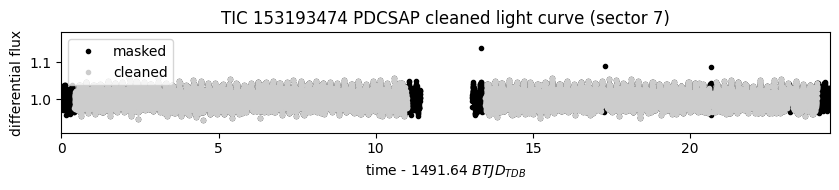

In [31]:
import matplotlib.pyplot as plt
import yaml

info = yaml.full_load(open(f"../data/{tic}/info.yaml", "r"))

plt.figure(None, (8.5, 2))
plt.plot(time, flux, ".", c="k", label="masked")
plt.plot(clean["time"], clean["flux"], ".", c="0.8", label="cleaned")
plt.xlabel(f"time - {info['time0']:.2f} ${info['time0_format']}$")
plt.ylabel("differential flux")
plt.title(f"TIC {info['tic']} PDCSAP cleaned light curve (sector {int(info['sector'])})")
plt.legend(loc="upper left")
std = np.std(flux) * 10
plt.ylim(1 - 0.5 * std, 1 + std)
plt.xlim(time.min(), time.max())
plt.tight_layout()
plt.savefig(f"../figures/{tic}_clean.png", dpi=200)